##Pilot some code for using scikit.learn regression

In [4]:
%pylab inline
import numpy as np
import pandas as pd

from os import path
from PIL import Image
from src import preprocessing as preproc
from sklearn import linear_model
from src import features
from scipy.ndimage.filters import convolve1d
from sklearn.metrics import explained_variance_score,r2_score
from scipy.stats import zscore

Populating the interactive namespace from numpy and matplotlib


###Create a set of model voxels

####Load in some wedge images for training

In [2]:
##the database
subject = 's1055'
db =  '/media/tnaselar/Data/July_2015_preproc/'+subject+'/PS/aligned_db.csv'
data_db = pd.io.parsers.read_csv(db,header=0)

##select the wedge/bar runs
def select_run(row,runType):
    return row['runType'] in [runType]
wedge_runs = list(data_db[data_db.apply(select_run,axis=1,args=('wedge',))].runID)
bar_runs = list(data_db[data_db.apply(select_run,axis=1,args=('bar',))].runID)

##some important units
image_downsampling = .1                           ##I choose this
pixel_per_deg = 34.751*image_downsampling         ##I just know this  
pixels_per_stimulus = int(768*image_downsampling) ##I just know this
wedge_nvols = data_db.iloc[wedge_runs[0]].nvols 
bar_nvols = data_db.iloc[bar_runs[0]].nvols

##load 'em up
wedge_stim_list = preproc.load_frame_file(data_db.iloc[wedge_runs[0]]) 
bar_stim_list = preproc.load_frame_file(data_db.iloc[bar_runs[0]])
pic_path = data_db.iloc[wedge_runs[0]].picPath




wedge_imgs = np.array(map(do1,
                          map(do2 )),
                      ndmin=3)

def lambda1(img):
    # arg : image path 
    # return : np.array() of that image
    return np.array( Image.open(img).convert('L').resize((pixels_per_stimulus,)*2))

def lambda2(f):
    # arg : file name
    # return : path + file name    
    return path.join(pic_path,f)

np.array( map(lambda1, map(lambda2, bar_stim_list) ),ndims=3)

for every bar_stim 




print 'wedge images taking up %0.3f GB of RAM' %(wedge_imgs.nbytes/1024./1024./1024.)
bar_imgs = np.array(map(lambda img: np.array( Image.open(img).convert('L').resize((pixels_per_stimulus,)*2)),
                          map(lambda f: path.join(pic_path,f),bar_stim_list)), ndmin=3)
print 'bar images taking up %0.3f GB of RAM' %(bar_imgs.nbytes/1024./1024./1024.)

wedge images taking up 0.024 GB of RAM
bar images taking up 0.024 GB of RAM


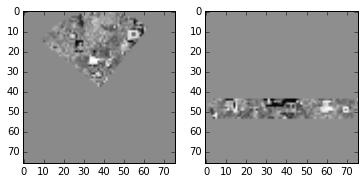

In [3]:
plt.figure
plt.subplot(1,2,1)
plt.imshow(wedge_imgs[500,:,:],cmap=cm.gray)
plt.subplot(1,2,2)
plt.imshow(bar_imgs[500,:,:],cmap=cm.gray)

####Generate a bunch of filters

In [209]:
freq = 4. #cyc/image
kernel_size = 20
kernel_spacing = 1
boundary_condition = 0

## [num_filters] x [pix_per_stim] x [pix_per_stim]
kernels = features.construct_kernel_set(freq,kernel_size,pixels_per_stimulus,kernel_spacing,boundary_condition=boundary_condition)

constructing 16 filters


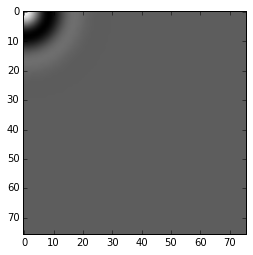

In [211]:
plt.figure
plt.imshow(np.real(kernels[0,:,:]),cmap=cm.gray)

####Filter the images

In [212]:
wedge_features = np.abs(np.einsum('kij,lij->kl', wedge_imgs, kernels))  ## time x filter

In [213]:
bar_features = np.abs(np.einsum('kij,lij->kl', bar_imgs, kernels))     ## time x filter

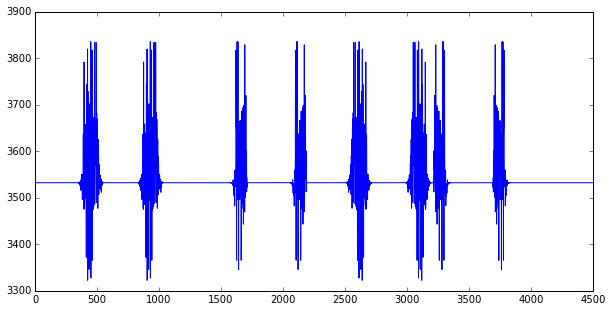

In [290]:
plt.figure(figsize=(10,5))
plt.plot(wedge_features[:,0])

####Construct a canonical irf

In [576]:
L = 20
def irf(x):
    return x*np.exp(-.4*x)

cannonical_irf = irf(np.arange(0,L))
# cannonical_irf = np.array([1]+[0]*99)[::-1]


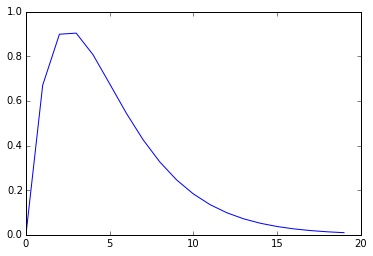

In [577]:
plt.figure
plt.plot(cannonical_irf.T)

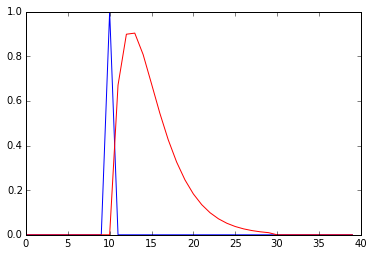

In [668]:
signal = np.zeros(2*L)
signal[int(L/2.)] = 1
conv = convolve1d(signal,cannonical_irf,origin=-int(L/2.),mode='wrap')
plt.figure
plt.plot(signal)
plt.plot(conv,'r',hold=True)

####For each filter, create one voxel that is a noisy convolution
Play with the noise factor. I've found that even when the "signal" is completely buried by the noise, it is still possible to fit the irf.

In [704]:
noise_factor = 1000
num_kernels = kernels.shape[0]
num_timepoints = wedge_features.shape[0]
wedge_voxels = convolve1d(wedge_features,cannonical_irf,axis=0,origin=-int(L/2.),mode='wrap')+np.random.rand(num_timepoints,num_kernels)*noise_factor
bar_voxels = convolve1d(bar_features,cannonical_irf, axis=0,origin=-int(L/2.), mode='wrap')+np.random.rand(num_timepoints,num_kernels)*noise_factor

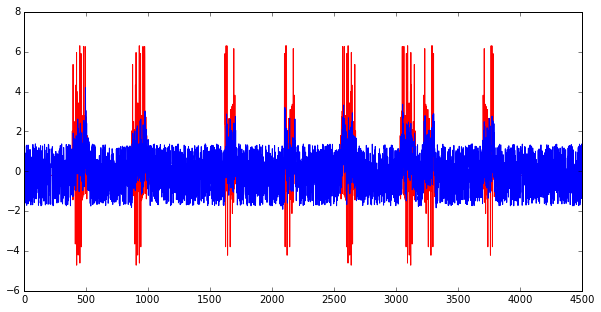

In [705]:
plt.figure(figsize=(10,5))
plt.plot(zscore(wedge_features[:,0]),'r',hold=True)
plt.plot(zscore(wedge_voxels[:,0]))

####Train the model
Loop over the filter positions, training a model for each.
Given the way we've designed our model voxels, each filter position should be optimal for
exactly one voxel.

In [706]:
alphas = np.logspace(np.log10(0.01), np.log10(1000),num=50)
kernel_positions = range(num_kernels)
model_grid = pd.DataFrame(None,index=kernel_positions,columns=alphas)

In [707]:
for kp in kernel_positions:
    fm = preproc.construct_feature_matrix(np.atleast_2d(wedge_features[:,kp]).T,hrf_length=L)
    for a in alphas:
        model_grid.ix[kp,a]=linear_model.Ridge(alpha=a,normalize=True,fit_intercept=True).fit(fm,wedge_voxels)

Look. If we take the first model, we get a decent-looking estimated hrf for the first voxel (blue),
but a shitty one for the last voxel (green). But if we take the last model, we get the opposite. Just as we expected.

Also, explore results with different values of  the Ridge argument "alpha". As it increases, the estimated hrf becomes more and more smooth.

If curious, also try the "Lasso" model, instead of ridge. With that model, as alpha increases, the estimated hrf becomes more sparse. For high enough alpha, only the very first in time point has a non-zero weight.

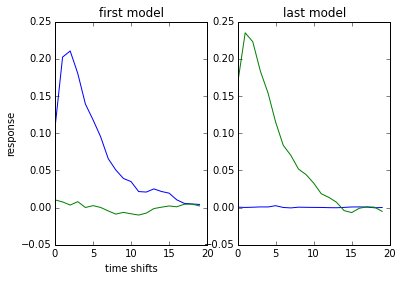

In [708]:
see_voxel_1 = 4
see_voxel_2 = -1
see_alpha = 25
plt.figure
plt.subplot(1,2,1)
plt.title('first model')
plt.xlabel('time shifts')
plt.ylabel('response')
plt.plot(model_grid.ix[kernel_positions[see_voxel_1],alphas[see_alpha]].coef_[[see_voxel_1,see_voxel_2],:].T)
plt.subplot(1,2,2)
plt.title('last model')
plt.plot(model_grid.ix[kernel_positions[see_voxel_2],alphas[see_alpha]].coef_[[0,see_voxel_2],:].T)

Find the best alpha and filter postion for each voxel -- create a "new" dataset (by adding different noise) for selection. This is to avoid overfitting.

Note the print out: the best kernel for each voxel is correct. The best alpha value will depend on the amount of noise pumped into the fake data. For high levels of noise, we want higher alphas to "smooth" out the model coefficients.

In [709]:
selection_data_voxels = convolve1d(wedge_features,cannonical_irf,axis=0,origin=-int(L/2.),mode='wrap')+np.random.rand(num_timepoints,num_kernels)*noise_factor
score_matrix = np.zeros((len(kernel_positions),len(kernel_positions),len(alphas)))
for ai,a in enumerate(alphas):
    for kp in kernel_positions:
        fm = preproc.construct_feature_matrix(np.atleast_2d(wedge_features[:,kp]).T,hrf_length=L)
        yhat = model_grid.ix[kernel_positions[kp],alphas[ai]].predict(fm)
        for v in kernel_positions:
            score_matrix[v,kp,ai] = r2_score(selection_data_voxels[:,v],yhat[:,v])
            
 

In [710]:
           
best_model = []
for v in kernel_positions:
    sm = score_matrix[v,:,:]
    i,j=np.unravel_index(sm.argmax(),sm.shape)
    best_model.append((i,j))
    print 'score for voxel %d, model (%d,%0.2f) |---> %0.2f' %(v,i,alphas[j], sm[i,j])
       

score for voxel 0, model (5,0.05) |---> 0.10
score for voxel 1, model (1,0.01) |---> 0.49
score for voxel 2, model (2,0.01) |---> 0.82
score for voxel 3, model (3,0.01) |---> 0.36
score for voxel 4, model (4,0.01) |---> 0.55
score for voxel 5, model (5,0.01) |---> 0.81
score for voxel 6, model (6,0.01) |---> 0.76
score for voxel 7, model (7,0.01) |---> 0.74
score for voxel 8, model (8,0.01) |---> 0.72
score for voxel 9, model (9,0.01) |---> 0.74
score for voxel 10, model (10,0.01) |---> 0.75
score for voxel 11, model (11,0.01) |---> 0.71
score for voxel 12, model (12,0.03) |---> 0.29
score for voxel 13, model (13,0.01) |---> 0.71
score for voxel 14, model (14,0.01) |---> 0.76
score for voxel 15, model (15,0.01) |---> 0.54


Check out predictions for one of the voxels -- for both the training and validation data.

In [711]:
this_voxel = 10
kp,ai = best_model[this_voxel]
a = alphas[ai]
fm = preproc.construct_feature_matrix(np.atleast_2d(wedge_features[:,kp]).T,hrf_length=L)
yhat = model_grid.ix[kp,a].predict(fm)

0.754829282424


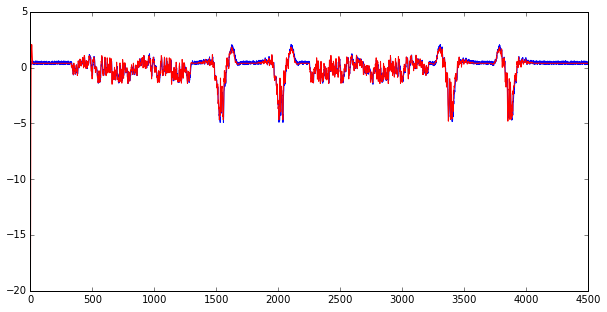

In [712]:
plt.figure(figsize=(10,5))
plt.plot(zscore(wedge_voxels[:,this_voxel]))
plt.plot(zscore(yhat[:,this_voxel]),'r',hold = True)
print r2_score(wedge_voxels[:,this_voxel],yhat[:,this_voxel])

####Test the model on different set of features
These scores are not nearly as good as the scores we saw above, but that's because we are now testing on a new
set of features. This is the "real" performance of the model.

0.451749296783


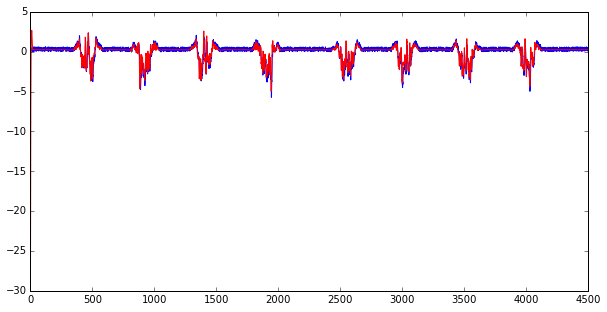

In [713]:
fm = preproc.construct_feature_matrix(np.atleast_2d(bar_features[:,kp]).T,hrf_length=L)
yhat = model_grid.ix[kp,a].predict(fm)

plt.figure(figsize=(10,5))
plt.plot(zscore(bar_voxels[:,this_voxel]))
plt.plot(zscore(yhat[:,this_voxel]),'r',hold = True)
print r2_score(bar_voxels[:,this_voxel],yhat[:,this_voxel])

In [714]:
for v in kernel_positions:
    kp,ai = best_model[v]
    a = alphas[ai]
    fm = preproc.construct_feature_matrix(np.atleast_2d(bar_features[:,kp]).T,hrf_length=L)
    yhat = model_grid.ix[kp,a].predict(fm)   
    sc = r2_score(bar_voxels[:,v],yhat[:,v])
    print 'score for voxel %d |---> %0.2f' %(v,sc)
    

score for voxel 0 |---> -0.00
score for voxel 1 |---> 0.39
score for voxel 2 |---> 0.63
score for voxel 3 |---> 0.23
score for voxel 4 |---> 0.36
score for voxel 5 |---> 0.45
score for voxel 6 |---> 0.52
score for voxel 7 |---> 0.41
score for voxel 8 |---> 0.58
score for voxel 9 |---> 0.48
score for voxel 10 |---> 0.45
score for voxel 11 |---> 0.25
score for voxel 12 |---> 0.24
score for voxel 13 |---> 0.35
score for voxel 14 |---> 0.42
score for voxel 15 |---> 0.25
